# Lecture 6: Support Vector Machines

The scikit-learn documentation has a nice write-up of support vector machines [here](http://scikit-learn.org/stable/modules/svm.html).  There are three different implementations: [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), which is the main one that we'll use, [NuSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC), which is a slightly different formulation, and [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), which only supports linear kernels but is faster on large datasets.  

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# this is a new import
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn import datasets
import seaborn as sns
from sklearn.grid_search import GridSearchCV

We're going to work with the by-now-nauseatingly-familiar iris dataset.  We'll build a binary model to predict species 2 vs species 3, using the first two features only, so that we can visualize it.

In [3]:
iris = datasets.load_iris()

X = iris.data
y = iris.target


X = X[y != 0, :2]
y = y[y != 0]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

Let's define a function that will train an SVM with a given kernel and a given value of the `C` and `gamma` parameters.  The function will return the trained model, the test predictions, and the test distances from the hyperplane.

In [21]:
def train_svm(kernel="linear", C=1.0, gamma=0.0):

    svm = SVC(kernel=kernel, degree=4, C=C, gamma=gamma)
    svm.fit(X_train, y_train)

    # predict on the test set
    y_preds = svm.predict(X_test)
    # get the distances from the hyperplane, the sign of which
    # is the prediction above
    y_dists = svm.decision_function(X_test)
    
    return (svm, y_preds, y_dists)

Let's define a function that will take a trained SVM and plot the 2-dimensional decision function, along with the training and test points.

In [6]:
def plot_svm(svm, X, X_test):

    # plot all of the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired)
    # put an extra circle on top of the test points
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)

    # step size of the mesh
    h = 0.01
    # range of the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    z = svm.decision_function(np.column_stack((xx.ravel(), yy.ravel())))

    z = z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, z > 0, cmap=plt.cm.Paired)
    # this will plot the contour lines of the decision function
    plt.contour(xx, yy, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
    levels=[-.5, 0, .5])

    plt.show()

First we'll train a linear SVM.

In [7]:
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=1.0)

In [8]:
y_preds_linear

array([2, 1, 1, 1, 2, 1, 1, 2, 1, 1])

In [9]:
y_dists_linear

array([ 0.11470521, -0.47536447, -0.96715813, -1.32805497,  1.06567172,
       -0.18032963, -0.34426085,  1.19677534, -0.21315723, -0.24619162])

We can see how many support vectors there are.  That is, how many points are on or inside of the margin.  This will return the number of support vectors of each class:

In [10]:
svm_linear.n_support_

array([32, 32], dtype=int32)

In [11]:
# indices of the support vectors
svm_linear.support_

array([ 0,  1,  2,  7, 10, 12, 15, 16, 17, 22, 24, 26, 31, 34, 35, 40, 44,
       45, 48, 53, 62, 66, 67, 69, 77, 78, 79, 80, 82, 85, 88, 89,  5,  6,
        8, 11, 13, 18, 19, 21, 28, 30, 32, 33, 36, 37, 39, 42, 43, 46, 50,
       51, 52, 54, 55, 57, 58, 65, 71, 73, 74, 76, 83, 87], dtype=int32)

In [12]:
# the vectors themselves
svm_linear.support_vectors_[0:5]

array([[ 6.1,  2.8],
       [ 6.3,  2.5],
       [ 5.8,  2.7],
       [ 5.8,  2.7],
       [ 6.7,  3. ]])

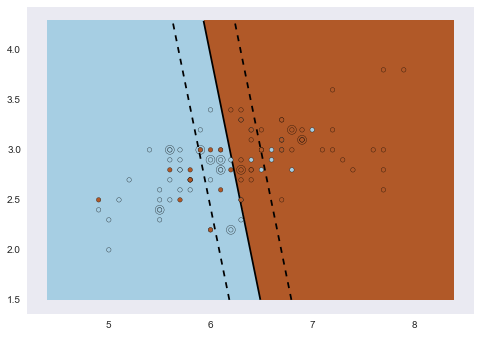

In [13]:
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=1.0)
plot_svm(svm_linear, X, X_test)

Let's try increasing the C parameter, which is the opposite of how ISLR defines it.  In ISLR, C is the budget for how many points are allowed to violate the margin.  So larger C means more violations are allowed.  In scikit-learn, it's the opposite.

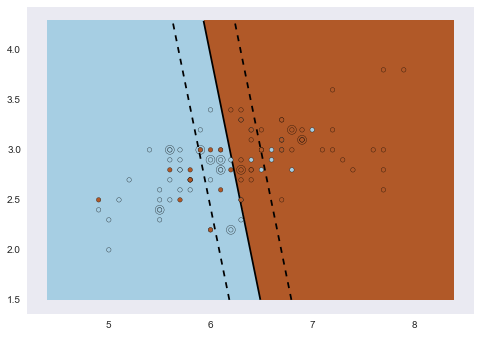

In [14]:
# C is the inverse of how ISLR defines it
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=1)
plot_svm(svm_linear, X, X_test)

In [ ]:
param_grid = {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [0.01, 1, 1.0]}

svm = SVC(kernel="linear")
cv = GridSearchCV(svm, param_grid, cv=5, n_jobs=4, refit=True)
cv.fit(X_train, y_train)

In [ ]:
cv.grid_scores_

Let's fit an SVM with a polynomial kernel of degree 2:

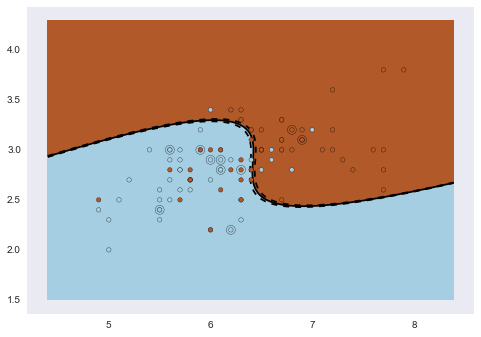

In [22]:
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", C=1.0, gamma=2)
plot_svm(svm_poly, X, X_test)

Let's fit an SVM with a polynomial kernel of degree 3:

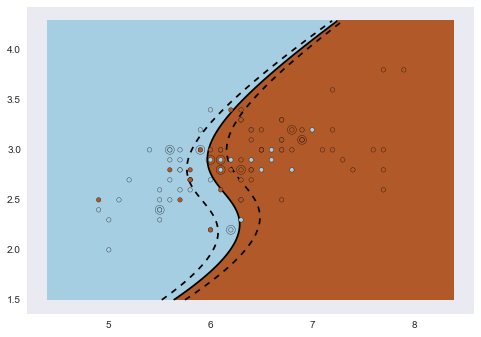

In [16]:
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", C=1.0, gamma=3)
plot_svm(svm_poly, X, X_test)

Let's fit an SVM with an RBF kernel:

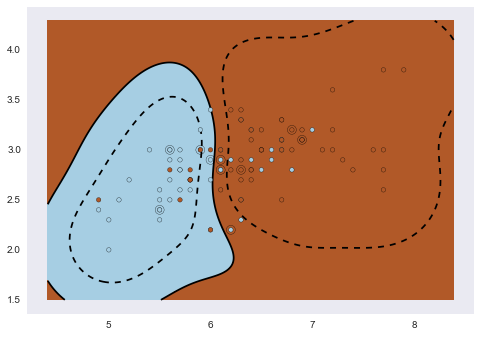

In [17]:
svm_rbf, y_preds_rbf, y_dists_rbf = train_svm("rbf", C=1.0, gamma=3)
plot_svm(svm_rbf, X, X_test)

Increasing the parameter of the RBF kernel makes us look at more and more local points, increasing the variance:

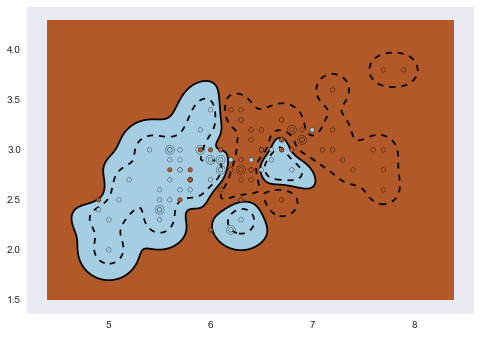

In [18]:
svm_rbf, y_preds_rbf, y_dists_rbf = train_svm("rbf", C=1.0, gamma=30)
plot_svm(svm_rbf, X, X_test)

## Text Classification

SVM's are quite ofen used in text classification problems.  Here, we're going to work through an example (a modified version of [this](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html)) using the 20 newsgroups dataset.

In [23]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

First we'll load the data:

In [24]:
data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', categories=None,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

In [25]:
data_train.keys()

['DESCR', 'data', 'target', 'target_names', 'filenames']

The data has postings from one of 20 "newsgroup" types.

In [26]:
len(data_train.data)

11314

In [27]:
data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The first trainging post comes from the "rec.autos" newsgroup:

In [28]:
data_train.target_names[data_train.target[0]]

'rec.autos'

And has the following contents:

In [29]:
data_train.data[0]

u'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

Let's make a binary target variable to predict whether a given post is in the "sci.space" newsgroup:

In [30]:
space_target = (data_train.target==14).astype("int")
space_target_test = (data_test.target==14).astype("int")

One way to turn a blob of text into features or predictors (to "vectorize" it) is to simply count up the number of times each word appears.

In [31]:
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

The features are the number of times each word in the "vocabulary" appears in a given post.  Note that, by far, most words won't show up in most posts, so the matrix of predcitors is very "sparse".

In [32]:
len(vectorizer.vocabulary_)

101323

In [33]:
vectorizer.vocabulary_

{u'3ds2scn': 6906,
 u'wax3': 95669,
 u'l1tbk': 55092,
 u'mbhi8bea': 60014,
 u'luanch': 57609,
 u'woods': 96905,
 u'ree84': 76655,
 u'mdbs': 60375,
 u'hanging': 45488,
 u'woody': 96912,
 u'trawling': 89838,
 u'localized': 57118,
 u'spidery': 84167,
 u'disobeying': 34056,
 u'canes': 25585,
 u'os2faq': 68487,
 u'sprague': 84354,
 u'chatter': 26775,
 u'5986': 9141,
 u'crossbar': 30540,
 u'rickman': 78144,
 u'showy': 82224,
 u'_xogkyrzaup': 15724,
 u'naturopathic': 64925,
 u'sowell': 83851,
 u'slqfbql': 83146,
 u'pigment': 71207,
 u'cfc': 26482,
 u'ua8cx': 90878,
 u'mahavolich': 59051,
 u'broward': 24269,
 u'bringing': 24159,
 u'1089': 1845,
 u'dascenzo': 31797,
 u'wooded': 96898,
 u'grueling': 44481,
 u'vibrational': 93992,
 u'wooden': 96899,
 u'wednesday': 95853,
 u'andrei_lomakin': 18531,
 u'circuitry': 27423,
 u'598n': 9142,
 u'crotch': 30563,
 u'jujuga': 52779,
 u'amplifications': 18329,
 u'v6jylh': 93118,
 u'xpknxekf5': 98517,
 u'immunities': 49091,
 u'spiders': 84165,
 u'2h5b8z': 552

In [34]:
X_train[0, :]

<1x101323 sparse matrix of type '<type 'numpy.int64'>'
	with 34 stored elements in Compressed Sparse Row format>

In [35]:
X_train[0, :].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [36]:
non_zeroes = np.array(np.where(X_train[0, :].todense())[1])[0]
non_zeroes

array([ 9843, 11174, 16806, 23430, 24108, 24583, 25437, 25717, 31927,
       34741, 34742, 35902, 37208, 37256, 41875, 46691, 49801, 54494,
       55607, 57248, 57251, 59072, 62595, 73175, 76270, 77677, 80421,
       81451, 83209, 84051, 84313, 87914, 96880, 99609])

Let's define a function that will take a list of indices and print the words from the vocabulary dictionary that correspond to those indices:

In [37]:
def print_words(index_list):
    for word, index in vectorizer.vocabulary_.iteritems():
        if index in index_list:
            print word

In [38]:
print_words(non_zeroes)

production
60s
years
addition
late
doors
car
history
engine
really
early
info
mail
body
separate
small
door
tellme
enlighten
wondering
bricklin
model
looked
bumper
rest
specs
looking
funky
70s
sports
saw
day
called
know


Let's train a linear, penalized SVM:

In [39]:
svm = LinearSVC(penalty='l2', C=1.0)
svm.fit(X_train, space_target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

One way to see what the SVM is doing is to look at the coefficients of each word, and to sort them from largest to smallest.  This will tell us which words are most associated with "space" in the posts:

In [40]:
top25 = np.argsort(svm.coef_.ravel())[-25:]
top25

array([42840, 48693, 96932, 30980, 93420, 27080, 71056, 83584, 80644,
       95447, 29442, 47333, 55654, 28346, 77661, 37981, 91338, 83872,
       15403, 68248, 24029, 83877, 92377, 81989, 50931])

In [41]:
svm.coef_.ravel()[top25]

array([ 0.53486528,  0.5417006 ,  0.5565858 ,  0.5565858 ,  0.55680755,
        0.5696352 ,  0.57438605,  0.59390485,  0.60549209,  0.60549209,
        0.61959557,  0.62138984,  0.62614615,  0.62897291,  0.63078795,
        0.64212055,  0.6422529 ,  0.65834809,  0.68366433,  0.71415891,
        0.72071181,  0.76821162,  0.9061624 ,  0.94590984,  1.25477334])

In [42]:
print_words(top25)

colonies
gee
schirra
space
breathing
wally
launch
varieties
choose
update
orbit
_perijoves_
umm
ironic
hover
sherzer
responses
contacting
ignorant
curiousity
spacecraft
photosynthetic
worden
solar
ether


[http://en.wikipedia.org/wiki/Wally_Schirra](http://en.wikipedia.org/wiki/Wally_Schirra)

Let's see how we do on a test set:

In [43]:
preds = svm.predict(X_test)

In [44]:
pd.crosstab(index=space_target_test, columns=preds, rownames=['True'], colnames=['Predicted'])

Predicted,0,1
True,,
0,7055,83
1,178,216
